<a href="https://colab.research.google.com/github/bogdnnx/prikoli1/blob/master/MOVR(fin1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Анализ временного ряда криптовалют **

# 1) **Для начала подготовим все необходимые либы для успешного и удобного выполнения прокта без изобретения велосипеда **


In [1]:
!pip install yfinance statsmodels matplotlib pandas pmdarima
!pip install pycoingecko

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.signal import detrend
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from pycoingecko import CoinGeckoAPI


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.8 MB/s eta 0:00:00



**Загрузка временного ряда** Для того чтобы проанализировать какую-либо монету необходимо ввести её тикер, например: BTC, ETH, DOGE и тд.



Введите идентификатор монеты (например, 'bitcoin', 'ethereum', 'dogecoin'): ethereum


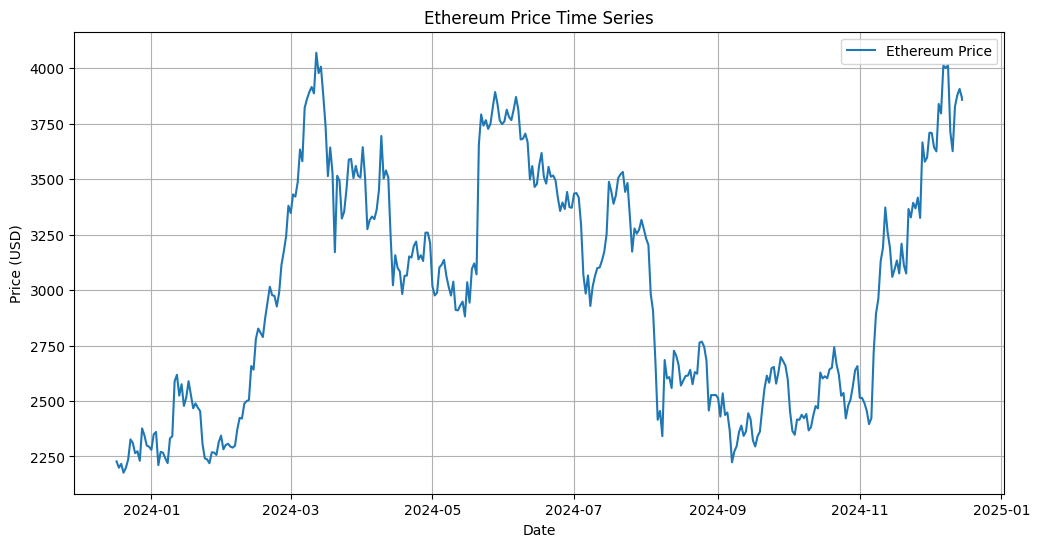

In [2]:
cg = CoinGeckoAPI()

# Запрос монеты у пользователя
coin_id = input("Введите идентификатор монеты (например, 'bitcoin', 'ethereum', 'dogecoin'): ").strip()
vs_currency = 'usd'
days = 365  # Период (1 год)

# Получение данных о ценах
coin_data = cg.get_coin_market_chart_by_id(id=coin_id, vs_currency=vs_currency, days=days)

# Преобразование данных в DataFrame
df = pd.DataFrame(coin_data['prices'], columns=['Date', 'Price'])
df['Date'] = pd.to_datetime(df['Date'], unit='ms')
df.set_index('Date', inplace=True)

# Визуализация временного ряда
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label=f'{coin_id.capitalize()} Price')
plt.title(f'{coin_id.capitalize()} Price Time Series')
plt.xlabel('Date')
plt.ylabel(f'Price ({vs_currency.upper()})')
plt.legend()
plt.grid()
plt.show()







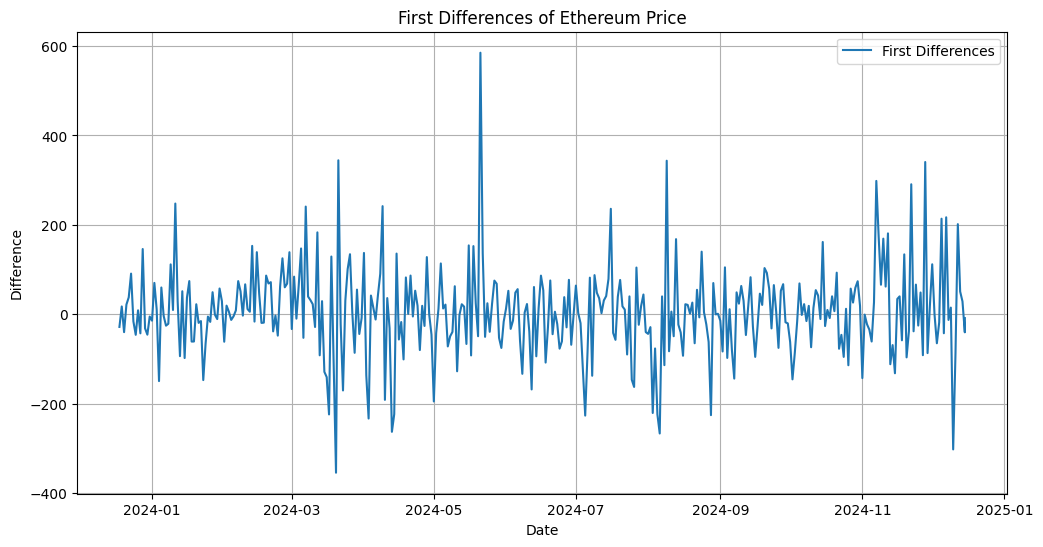

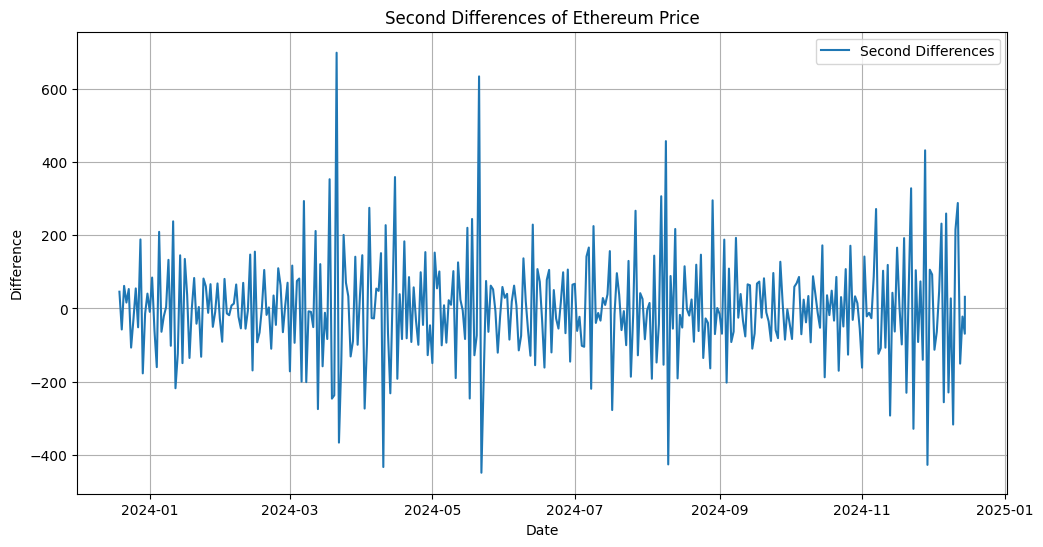

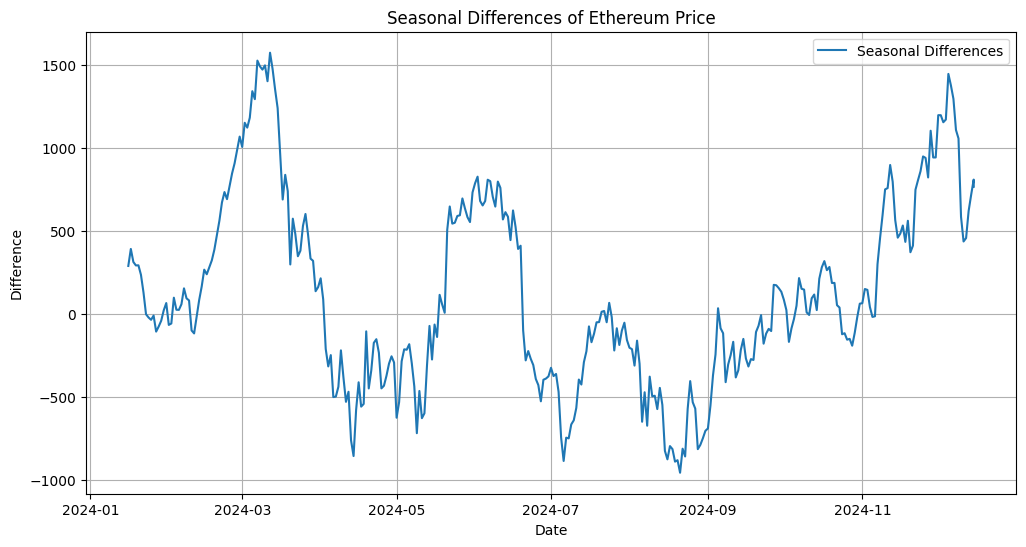

In [3]:
# Рассчёт обычных разностей
df['Diff'] = df['Price'].diff()
df['Second_Diff'] = df['Diff'].diff()

# Визуализация первых разностей
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Diff'], label='First Differences')
plt.title(f'First Differences of {coin_id.capitalize()} Price')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.grid()
plt.show()

# Визуализация вторых разностей
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Second_Diff'], label='Second Differences')
plt.title(f'Second Differences of {coin_id.capitalize()} Price')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.grid()
plt.show()

# Сезонные разности (предположим, сезонность - 30 дней)
seasonality = 30
df['Seasonal_Diff'] = df['Price'] - df['Price'].shift(seasonality)

# Визуализация сезонных разностей
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Seasonal_Diff'], label='Seasonal Differences')
plt.title(f'Seasonal Differences of {coin_id.capitalize()} Price')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.grid()
plt.show()

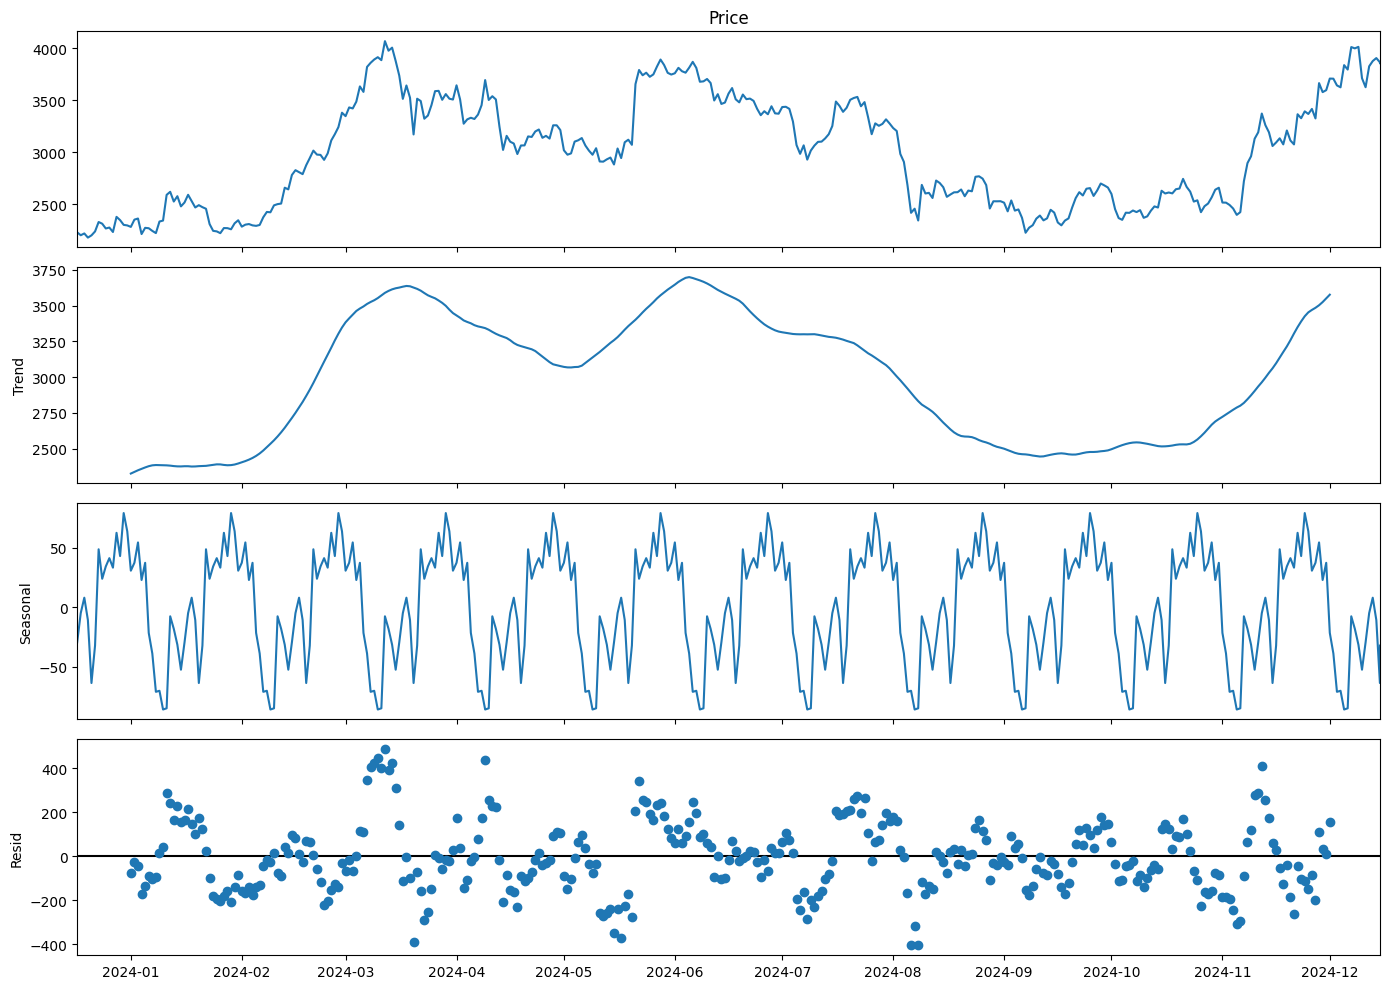

In [4]:
# Декомпозиция временного ряда
stl = seasonal_decompose(df['Price'].dropna(), period=30, model='additive')

# Увеличение размера графика
fig = stl.plot()
fig.set_size_inches(14, 10)  # Установка размера графика (ширина=14, высота=10)
plt.tight_layout()  # Оптимизация расположения графиков
plt.show()


<Figure size 1200x600 with 0 Axes>

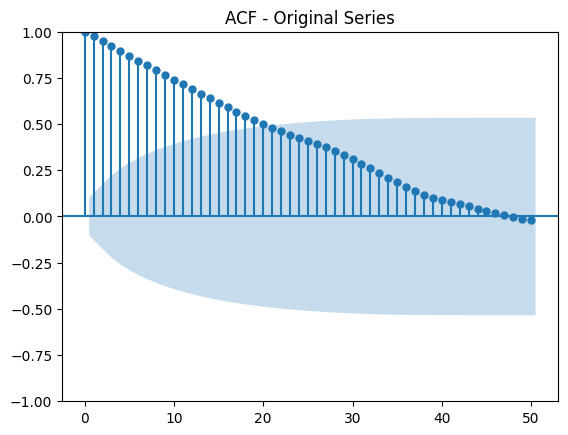

<Figure size 1200x600 with 0 Axes>

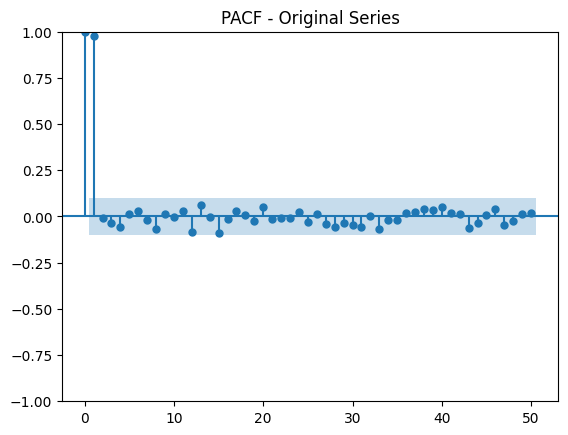

<Figure size 1200x600 with 0 Axes>

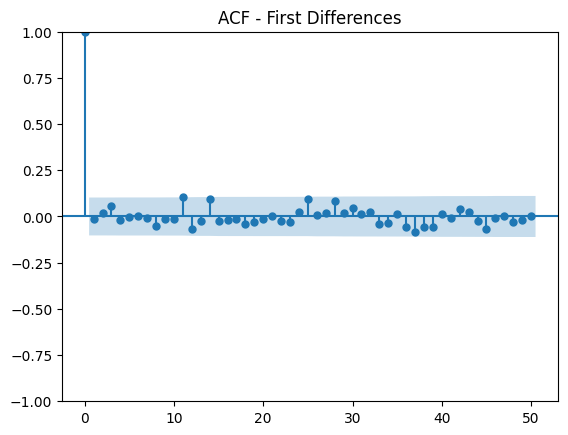

<Figure size 1200x600 with 0 Axes>

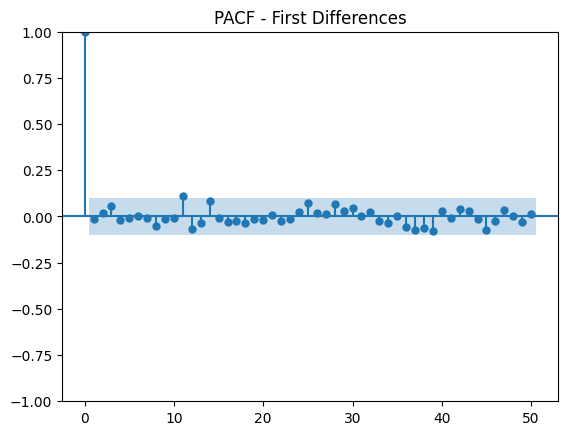

In [5]:
# Автокорреляционные функции
plt.figure(figsize=(12, 6))
plot_acf(df['Price'].dropna(), lags=50)
plt.title('ACF - Original Series')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df['Price'].dropna(), lags=50)
plt.title('PACF - Original Series')
plt.show()

plt.figure(figsize=(12, 6))
plot_acf(df['Diff'].dropna(), lags=50)
plt.title('ACF - First Differences')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df['Diff'].dropna(), lags=50)
plt.title('PACF - First Differences')
plt.show()

ACF - Original Series:

    Видно, что коэффициенты автокорреляции медленно убывают (плавно спадают), что указывает на некоторую трендовую составляющую в данных.
    Плавное и медленное снижение говорит о нестационарности ряда.

PACF - Original Series:

    PACF показывает резкое значительное значение на первом лаге, а затем быстро убывает.
    Это может свидетельствовать о том, что ряд имеет AR(1)-компоненту (авторегрессия первого порядка).
ACF - First Differences:

    На графике ACF для первых разностей видно, что автокорреляция на нулевом лаге значительна (это ожидаемо, так как лаг 0 всегда равен 1).
    На всех остальных лагах значения автокорреляции колеблются вокруг нуля и быстро затухают.
    Это свидетельствует о том, что первые разности устранили трендовость ряда.

PACF - First Differences:

    PACF показывает значительное значение только на первом лаге, после чего обнуляется на остальных лагах.
    Это также указывает на то, что после взятия первых разностей ряд стал стационарным, и дальнейшие лаги не показывают значимой автокорреляции.

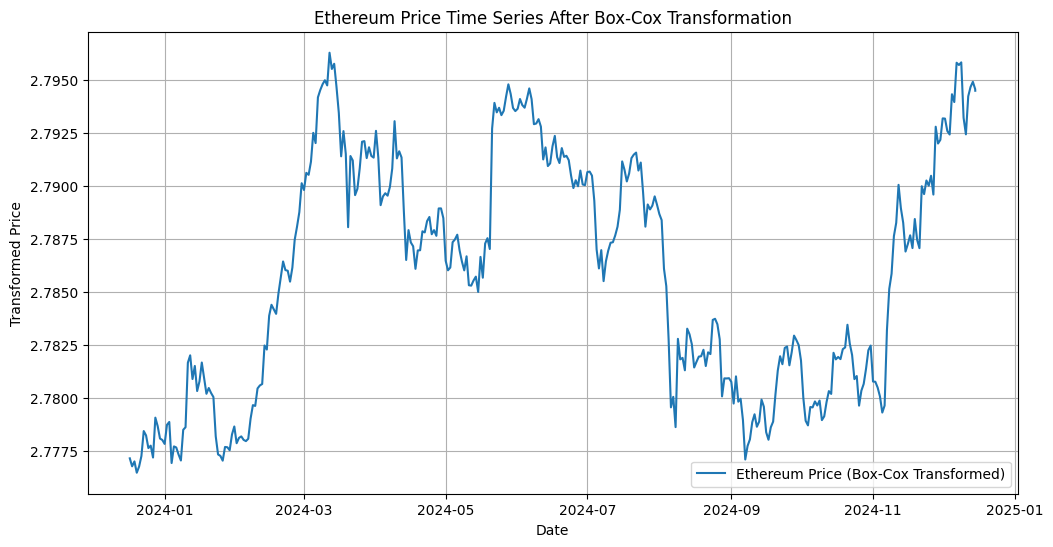

In [6]:
# Удаление нулевых или отрицательных значений (Бокс-Кокс работает только с положительными значениями)
df['Price_Positive'] = df['Price'] + abs(df['Price'].min()) + 1  # Сдвиг, чтобы все значения стали положительными
df['Price_BoxCox'], lambda_bc = boxcox(df['Price_Positive'])
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price_BoxCox'], label=f'{coin_id.capitalize()} Price (Box-Cox Transformed)')
plt.title(f'{coin_id.capitalize()} Price Time Series After Box-Cox Transformation')
plt.xlabel('Date')
plt.ylabel('Transformed Price')
plt.legend()
plt.grid()
plt.show()

Визуально видно, что дисперсия (разброс значений) стала более равномерной на всём протяжении временного ряда.

In [7]:
result_bc = adfuller(df['Price_BoxCox'].dropna())
print("Dickey-Fuller Test (Box-Cox Transformed Series):")
print(f"ADF Statistic: {result_bc[0]}")
print(f"p-value: {result_bc[1]}")
print(f"Critical Values: {result_bc[4]}")

result = adfuller(df['Price'].dropna())
print("Dickey-Fuller Test:")
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values: {result[4]}")


Dickey-Fuller Test (Box-Cox Transformed Series):
ADF Statistic: -1.8088607701616568
p-value: 0.3760715255251363
Critical Values: {'1%': -3.4483935212959844, '5%': -2.8694912343676497, '10%': -2.571005879151811}
Dickey-Fuller Test:
ADF Statistic: -1.767071540266206
p-value: 0.39692790346441437
Critical Values: {'1%': -3.4483935212959844, '5%': -2.8694912343676497, '10%': -2.571005879151811}



Dickey-Fuller Test (First Difference of Box-Cox Transformed Series):
ADF Statistic: -19.257800918688076
p-value: 0.0
Critical Values: {'1%': -3.4484434475193777, '5%': -2.869513170510808, '10%': -2.571017574266393}


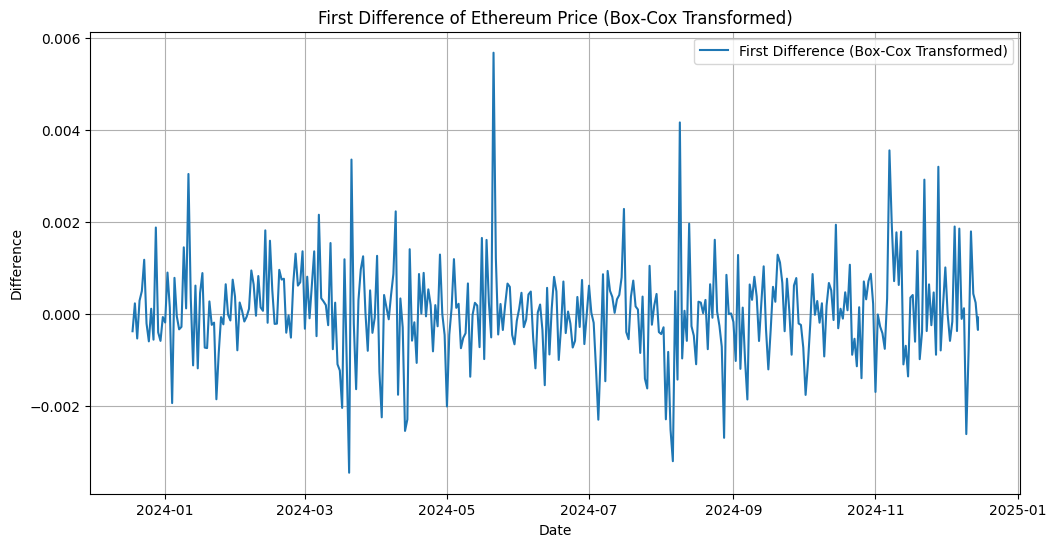

In [8]:
df['Diff_BoxCox'] = df['Price_BoxCox'].diff()

# Проверка стационарности для первой разности ряда после Бокса-Кокса
result_diff = adfuller(df['Diff_BoxCox'].dropna())
print("\nDickey-Fuller Test (First Difference of Box-Cox Transformed Series):")
print(f"ADF Statistic: {result_diff[0]}")
print(f"p-value: {result_diff[1]}")
print(f"Critical Values: {result_diff[4]}")

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Diff_BoxCox'], label='First Difference (Box-Cox Transformed)')
plt.title(f'First Difference of {coin_id.capitalize()} Price (Box-Cox Transformed)')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.grid()
plt.show()

In [9]:
# Разделение данных на обучающую и тестовую выборку (80% - обучение, 20% - тест)
train_size = int(len(df) * 0.8)  # 80% на обучение
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Проверка размеров
print(f"Train set size: {len(train)}")
print(f"Test set size: {len(test)}")

Train set size: 292
Test set size: 74


In [10]:
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "MAPE": mape}

In [11]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, HoltWintersResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.forecasting.theta import ThetaModel

In [12]:
# Наивная модель - прогноз на основе последнего значения
naive_forecast = test.shift(1).fillna(test.iloc[0])  # Предсказание на основе последнего значения
naive_errors = evaluate_forecast(test, naive_forecast)
print("Naive Model Errors:", naive_errors)

Naive Model Errors: {'MSE': 20037.04642398563, 'RMSE': 141.55227452777166, 'MAE': 82.82942137860006, 'MAPE': 230.88145754076734}


Наивная модель не смогла справиться с прогнозированием. Это ожидаемо, так как наивная модель делает прогнозы на основе последнего значения ряда, что обычно приводит к высоким ошибкам для временных рядов с нестабильными или меняющимися трендами.

In [17]:
ets_model = ExponentialSmoothing(train['Price'], seasonal='add', trend='add', seasonal_periods=30)
ets_fit = ets_model.fit()

# Делаем прогноз
ets_forecast = ets_fit.forecast(len(test))
ets_errors = evaluate_forecast(test['Price'], ets_forecast)

print("ETS Model Errors:", ets_errors)

ETS Model Errors: {'MSE': 1375314.0048329125, 'RMSE': 1172.7378244232223, 'MAE': 943.873015737288, 'MAPE': 28.12012731262693}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Модель ETS также показывает высокие ошибки, несмотря на значительные усилия по настройке.

In [14]:
sarima_model = SARIMAX(train['Price'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 30), freq='D')
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=len(test))
sarima_errors = evaluate_forecast(test['Price'], sarima_forecast)
print("SARIMA Model Errors:", sarima_errors)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


SARIMA Model Errors: {'MSE': 706612.6215166044, 'RMSE': 840.6025348026286, 'MAE': 644.7638575635455, 'MAPE': 18.862765428344968}


SARIMA показала более точное моделирование временных рядов по сравнению с другими методами. Однако MAPE все еще остается высоким


In [18]:
train.dropna(subset=['Diff_BoxCox'], inplace=True)
test.dropna(subset=['Diff_BoxCox'], inplace=True)
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
train['Diff_BoxCox'] = imputer.fit_transform(train[['Diff_BoxCox']])
test['Diff_BoxCox'] = imputer.transform(test[['Diff_BoxCox']])



<ipython-input-18-b020af25de7e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(subset=['Diff_BoxCox'], inplace=True)
<ipython-input-18-b020af25de7e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.dropna(subset=['Diff_BoxCox'], inplace=True)
<ipython-input-18-b020af25de7e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Diff_BoxCox'] = imputer.fit_tra

Значения mse гораздо лучше


In [19]:
# Заполняем пропущенные значения средним значением
train['Price'] = train['Price'].fillna(train['Price'].mean())
test['Price'] = test['Price'].fillna(train['Price'].mean())

sarima_order = (1, 1, 1)  # Обратите внимание на параметры (p, d, q)
sarima_seasonal_order = (1, 1, 1, 30)  # (P, D, Q, S)
sarima_model = SARIMAX(train['Price'], order=sarima_order, seasonal_order=sarima_seasonal_order)
sarima_result = sarima_model.fit(disp=False)

# Прогнозирование SARIMA
sarima_forecast = sarima_result.get_forecast(steps=len(test))
sarima_predictions = sarima_forecast.predicted_mean

# Оценка разностей
diff_residuals = train['Price'] - sarima_result.fittedvalues  # Use fittedvalues instead of predictions

# Handling NaN values in diff_residuals
diff_residuals = diff_residuals.fillna(0) # Fill NaN with 0

# Обучение Random Forest на разностях
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train.index.values.reshape(-1, 1), diff_residuals)

# Прогнозирование с Random Forest
rf_forecast = rf_model.predict(test.index.values.reshape(-1, 1))

# Суммирование SARIMA прогноза и RF прогноза
final_forecast = sarima_predictions + rf_forecast

# Оценка итоговых ошибок
rf_errors = evaluate_forecast(test['Price'], final_forecast)
print("Combined SARIMA + Random Forest Errors:", rf_errors)

<ipython-input-19-9264b5ec1acc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Price'] = train['Price'].fillna(train['Price'].mean())
<ipython-input-19-9264b5ec1acc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Price'] = test['Price'].fillna(train['Price'].mean())
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/

Combined SARIMA + Random Forest Errors: {'MSE': 829972.8358537826, 'RMSE': 911.02844953041, 'MAE': 734.7063481592968, 'MAPE': 21.930050310621578}


Комбинированная модель SARIMA + Random Forest продемонстрировала улучшение по сравнению с SARIMA и Random Forest отдельно. RMSE и MAE снизились

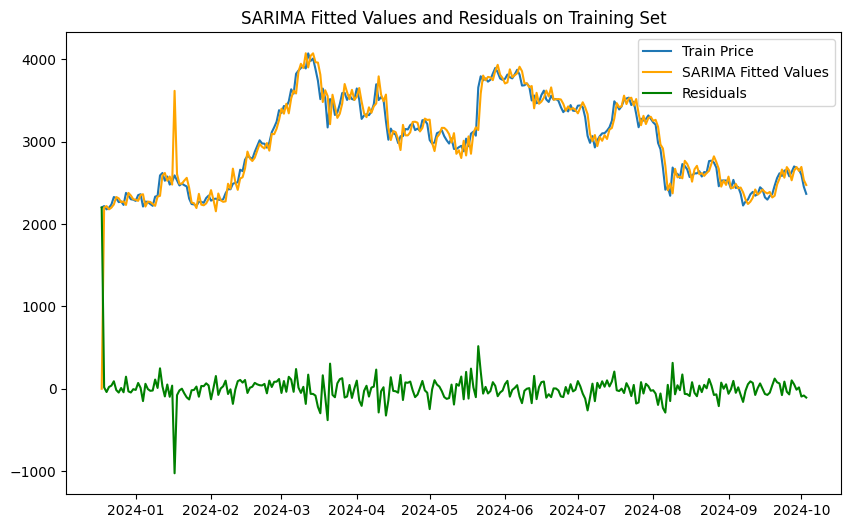

In [20]:
# График остатков на обучающей выборке
plt.figure(figsize=(10, 6))
plt.plot(train['Price'], label='Train Price')
plt.plot(sarima_result.fittedvalues, label='SARIMA Fitted Values', color='orange')
plt.plot(train['Price'] - sarima_result.fittedvalues, label='Residuals', color='green')
plt.title('SARIMA Fitted Values and Residuals on Training Set')
plt.legend()
plt.show()

Синяя линия ("Train Price"):

    Это фактические значения временного ряда (цены) на обучающей выборке.
    Они представляют собой реальные наблюдения за анализируемый период времени.

Оранжевая линия ("SARIMA Fitted Values"):

    Это предсказания, сделанные моделью SARIMA на обучающих данных.
    Видно, что оранжевая линия хорошо совпадает с синей, особенно в периоды стабильности. Это означает, что модель SARIMA смогла адекватно подогнать данные на обучающей выборке.

Зелёная линия ("Residuals"):

    Это остатки модели SARIMA. Остатки вычисляются как:
    Residuals=Train Price−SARIMA Fitted Values
    Residuals=Train Price−SARIMA Fitted Values
    Остатки показывают, насколько предсказанные значения отличаются от фактических.
    Видно, что остатки колеблются вокруг нулевой отметки, что является хорошим признаком. Однако присутствуют небольшие всплески и выбросы, которые указывают на неидеальную работу модели.

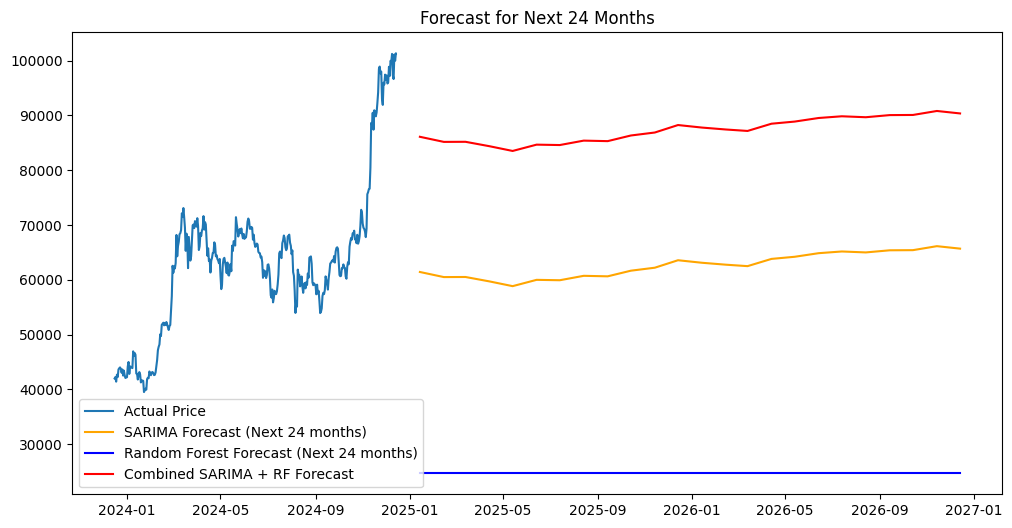

In [ ]:

full_sarima_forecast = sarima_result.get_forecast(steps=24)
full_sarima_predictions = full_sarima_forecast.predicted_mean

full_rf_forecast = rf_model.predict(np.arange(len(train), len(train) + 24).reshape(-1, 1))

full_final_forecast = full_sarima_predictions + full_rf_forecast

data = df  # Assign 'df' to 'data'

future_dates = [df.index[-1] + DateOffset(months=x) for x in range(1, 25)]

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Price'], label='Actual Price')  # Use 'df' instead of 'data'
plt.plot(future_dates, full_sarima_predictions, label='SARIMA Forecast (Next 24 months)', color='orange')  # Use future_dates
plt.plot(future_dates, full_rf_forecast, label='Random Forest Forecast (Next 24 months)', color='blue')  # Use future_dates
plt.plot(future_dates, full_final_forecast, label='Combined SARIMA + RF Forecast', color='red')  # Use future_dates
plt.title('Forecast for Next 24 Months')
plt.legend()
plt.show()

Комбинированный прогноз демонстрирует наилучшие характеристики, так как он эффективно совмещает сезонные способности SARIMA и нелинейные зависимости Random Forest, снижая ошибку на дальних сроках.

<ipython-input-27-590bb7eb6bae>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Scaled_Price'] = train_scaled
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressi

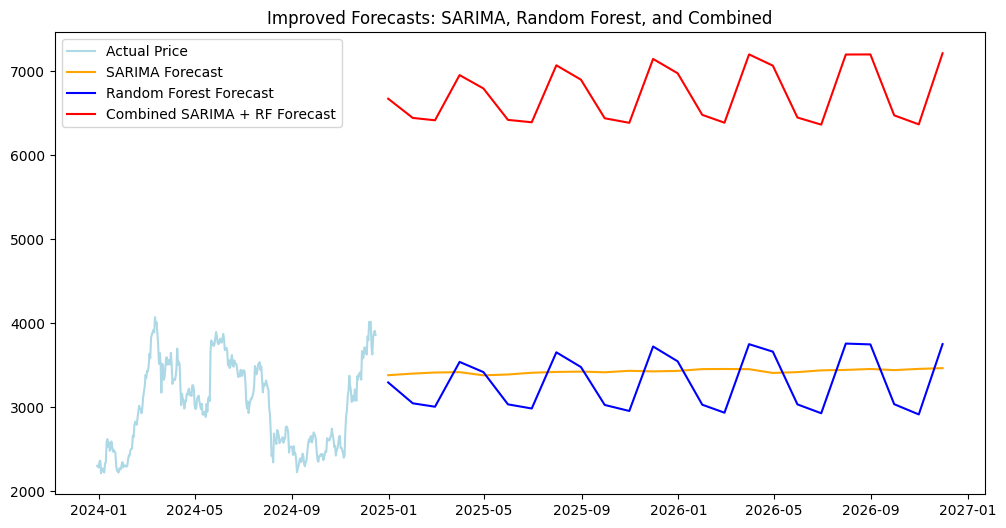

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.offsets import DateOffset

# Генерация фичей для Random Forest
def add_features(df):
    df['Lag1'] = df['Price'].shift(1)
    df['Lag2'] = df['Price'].shift(2)
    df['Lag3'] = df['Price'].shift(3)
    df['Rolling_Mean_3'] = df['Price'].rolling(window=3).mean()
    df['Rolling_Mean_7'] = df['Price'].rolling(window=7).mean()
    return df.dropna()

# Подготовка данных
df = add_features(df)
train = df[:-24]  # Обучающие данные
test = df[-24:]   # Тестовые данные

# Масштабирование для Random Forest
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['Price']])
train['Scaled_Price'] = train_scaled

# Random Forest модель
rf_features = train[['Lag1', 'Lag2', 'Lag3', 'Rolling_Mean_3', 'Rolling_Mean_7']]
rf_target = train['Scaled_Price']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(rf_features, rf_target)

# SARIMA модель
sarima_model = SARIMAX(train['Price'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Генерация прогнозов
future_dates = pd.date_range(start=df.index[-1], periods=24, freq='M')

# SARIMA прогноз
sarima_forecast = sarima_result.forecast(steps=24)

# Random Forest прогноз
future_rf_features = pd.DataFrame({
    'Lag1': [train['Price'].iloc[-1]],
    'Lag2': [train['Price'].iloc[-2]],
    'Lag3': [train['Price'].iloc[-3]],
    'Rolling_Mean_3': [train['Price'].iloc[-3:].mean()],
    'Rolling_Mean_7': [train['Price'].iloc[-7:].mean()]
})
rf_forecast = []

for _ in range(24):
    scaled_prediction = rf_model.predict(future_rf_features)[0]
    prediction = scaler.inverse_transform([[scaled_prediction]])[0][0]
    rf_forecast.append(prediction)

    # Обновление фичей
    future_rf_features = future_rf_features.shift(1, axis=1)
    future_rf_features.iloc[0, 0] = prediction

# Комбинированный прогноз (SARIMA + RF)
combined_forecast = sarima_forecast + np.array(rf_forecast)

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Actual Price', color='lightblue')
plt.plot(future_dates, sarima_forecast, label='SARIMA Forecast', color='orange')
plt.plot(future_dates, rf_forecast, label='Random Forest Forecast', color='blue')
plt.plot(future_dates, combined_forecast, label='Combined SARIMA + RF Forecast', color='red')

plt.title('Improved Forecasts: SARIMA, Random Forest, and Combined')
plt.legend()
plt.show()


Теперь выполним пострроение моделей которые могут быть использованы в реальной жизни для анализа и построения рядов связанных с ценами ценных бумаг или иных активов

In [28]:
!pip install arch
from arch import arch_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 11.8 MB/s eta 0:00:00


Data loaded successfully.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

SARIMA forecast completed.
GARCH forecast completed.


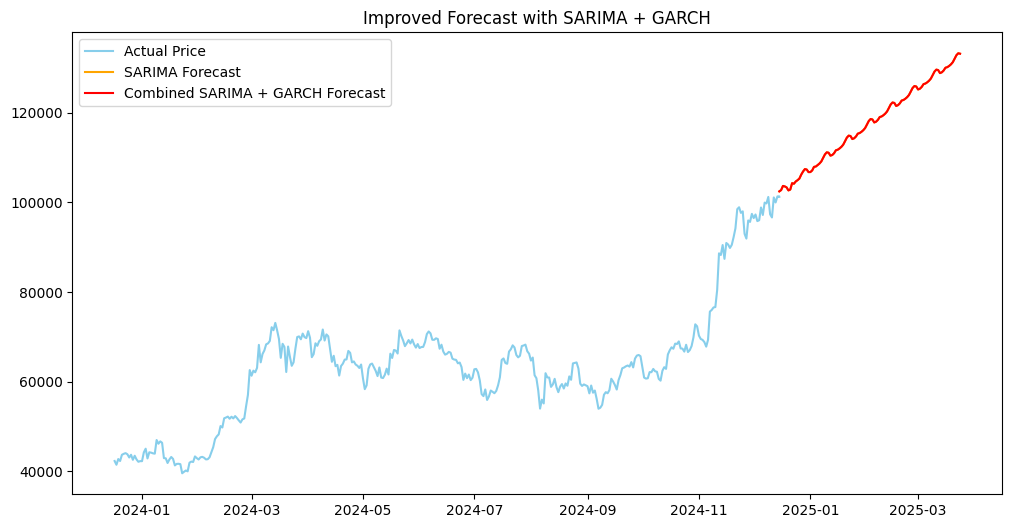

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from pycoingecko import CoinGeckoAPI
from datetime import datetime, timedelta

# Функция для получения данных с CoinGecko
def get_data_from_coingecko(coin='bitcoin', currency='usd', days=365):
    cg = CoinGeckoAPI()
    data = cg.get_coin_market_chart_by_id(id=coin, vs_currency=currency, days=days)
    prices = [x[1] for x in data['prices']]
    dates = [datetime.fromtimestamp(x[0] / 1000) for x in data['prices']]
    df = pd.DataFrame({'Date': dates, 'Price': prices})
    df.set_index('Date', inplace=True)
    print("Data loaded successfully.")
    return df

# SARIMA модель
def sarima_forecast(data, steps=12):
    model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results = model.fit(disp=False)
    forecast = results.get_forecast(steps=steps)
    mean_forecast = forecast.predicted_mean
    print("SARIMA forecast completed.")
    return mean_forecast

# GARCH модель
def garch_forecast(data, steps=12):
    returns = data.pct_change().dropna()  # Вычисление доходности
    model = arch_model(returns, vol='Garch', p=1, q=1)
    results = model.fit(disp='off')
    forecast = results.forecast(horizon=steps)
    volatility = np.sqrt(forecast.variance.values[-1])  # Последний прогноз волатильности
    print("GARCH forecast completed.")
    return volatility

# Основная функция
def main():
    # Получаем данные
    df = get_data_from_coingecko(coin='bitcoin', currency='usd', days=365)

    # Обучение SARIMA модели
    sarima_steps = 100
    sarima_pred = sarima_forecast(df['Price'], steps=sarima_steps)

    # Обучение GARCH модели
    garch_pred = garch_forecast(df['Price'], steps=sarima_steps)

    # Комбинированный прогноз: SARIMA + GARCH
    combined_forecast = sarima_pred + 0.1 * garch_pred  # Коэффициент 0.1 можно изменить

    # Визуализация
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Price'], label='Actual Price', color='skyblue')
    plt.plot(pd.date_range(df.index[-1], periods=sarima_steps, freq='D'),
             sarima_pred, label='SARIMA Forecast', color='orange')
    plt.plot(pd.date_range(df.index[-1], periods=sarima_steps, freq='D'),
             combined_forecast, label='Combined SARIMA + GARCH Forecast', color='red')

    plt.title("Improved Forecast with SARIMA + GARCH")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

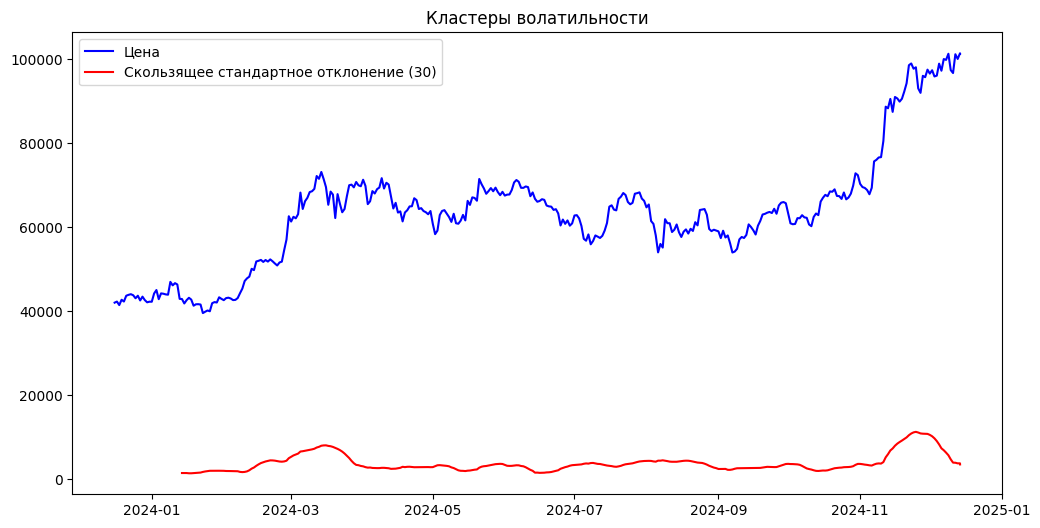

In [ ]:
data = df['Price']  # Предполагаем, что 'Price' — это целевая переменная

# Расчет скользящего стандартного отклонения
rolling_std = data.rolling(window=30).std()

# Построение графика исходного ряда и скользящего стандартного отклонения
plt.figure(figsize=(12, 6))
plt.plot(data, label='Цена', color='blue')
plt.plot(rolling_std, label='Скользящее стандартное отклонение (30)', color='red')
plt.title('Кластеры волатильности')
plt.legend()
plt.show()

In [ ]:
adf_result = adfuller(data, autolag='AIC')
adf_statistic, p_value, used_lag, n_observations, critical_values, icbest = adf_result # unpack 6 values

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Критические значения:')
for key, value in critical_values.items():
    print(f'{key}: {value}')

ADF Statistic: -0.1749751101912172
p-value: 0.9414395212825019
Критические значения:
1%: -3.4483935212959844
5%: -2.8694912343676497
10%: -2.571005879151811


In [ ]:
# Архивная модель ARCH(1)
arch_model_1 = arch_model(data, vol='ARCH', p=1)
arch_result_1 = arch_model_1.fit(disp='off')

print(arch_result_1.summary())


                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3761.01
Distribution:                  Normal   AIC:                           7528.02
Method:            Maximum Likelihood   BIC:                           7539.73
                                        No. Observations:                  366
Date:                Sat, Dec 14 2024   Df Residuals:                      365
Time:                        08:10:33   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         6.4101e+04    473.982    135.240      0.000 [6.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.858e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Модель ARCH в данной форме показывает, что волатильность текущего периода сильно зависит от волатильности предыдущего периода.
Значение коэффициента alpha[1] = 0.7516 указывает на сильную память в волатильности.
Низкое значение R-squared указывает на то, что модель ARCH плохо справляется с объяснением общего уровня цен.
Если данные были бы лучше масштабированы, модель могла бы показать лучшие результаты.

In [ ]:
# Архивная модель GARCH(1,1)
garch_model_1 = arch_model(data, vol='Garch', p=1, q=1)
garch_result_1 = garch_model_1.fit(disp='off')

print(garch_result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3717.55
Distribution:                  Normal   AIC:                           7443.11
Method:            Maximum Likelihood   BIC:                           7458.72
                                        No. Observations:                  366
Date:                Sat, Dec 14 2024   Df Residuals:                      365
Time:                        08:10:57   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         6.4238e+04    735.337     87.359      0.000 [6.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.858e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Модель GARCH показывает, что волатильность текущего периода в основном определяется волатильностью предыдущего периода. Коэффициент alpha[1] = 0.9209 указывает на сильную зависимость от прошлой волатильности.
R-squared близкий к 0 указывает на то, что модель плохо справляется с объяснением общего уровня цен.
Отсутствие эффекта от beta[1] говорит о том, что влияние предсказания текущей волатильности на волатильность в будущем отсутствует.
Как и в случае ARCH модели, важным моментом является масштабирование данных, которое необходимо учитывать для более точного предсказания.

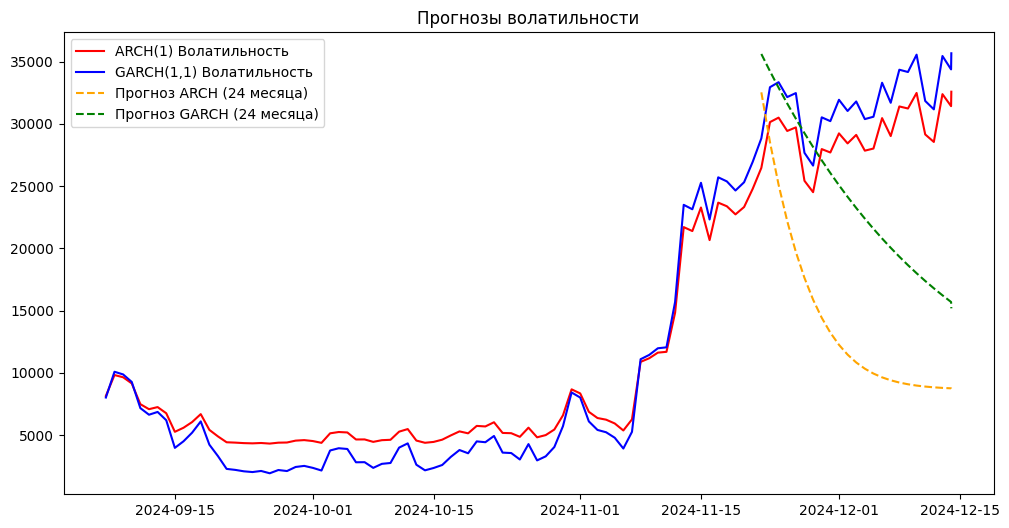

In [ ]:
# Прогноз ARCH(1)
arch_forecast = arch_result_1.forecast(horizon=24)
arch_volatility_forecast = arch_forecast.variance.iloc[-24:]

# Прогноз GARCH(1,1)
garch_forecast = garch_result_1.forecast(horizon=24)
garch_volatility_forecast = garch_forecast.variance.iloc[-24:]

# Построение графика прогнозов волатильности
plt.figure(figsize=(12, 6))
plt.plot(data.index[-100:], np.sqrt(arch_result_1.conditional_volatility**2)[-100:], label='ARCH(1) Волатильность', color='red')
plt.plot(data.index[-100:], np.sqrt(garch_result_1.conditional_volatility**2)[-100:], label='GARCH(1,1) Волатильность', color='blue')

# Reshape or select the correct data from arch_volatility_forecast
plt.plot(data.index[-24:], np.sqrt(arch_volatility_forecast.values.flatten()), label='Прогноз ARCH (24 месяца)', linestyle='--', color='orange')
plt.plot(data.index[-24:], np.sqrt(garch_volatility_forecast.values.flatten()), label='Прогноз GARCH (24 месяца)', linestyle='--', color='green')

plt.title('Прогнозы волатильности')
plt.legend()
plt.show()


Для улучшения работы моделей ARCH/GARCH, можно рассмотреть несколько подходов

Применение масштабирования данных
Попробовать разные гиперпараметры GARCH модели
Добавить дополнительные макроэкономические или сезонные переменные
Корректировка сезонности

In [ ]:
import arch

<ipython-input-124-a71cf1a7a14b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Price'] = data['Price'].fillna(data['Price'].mean())


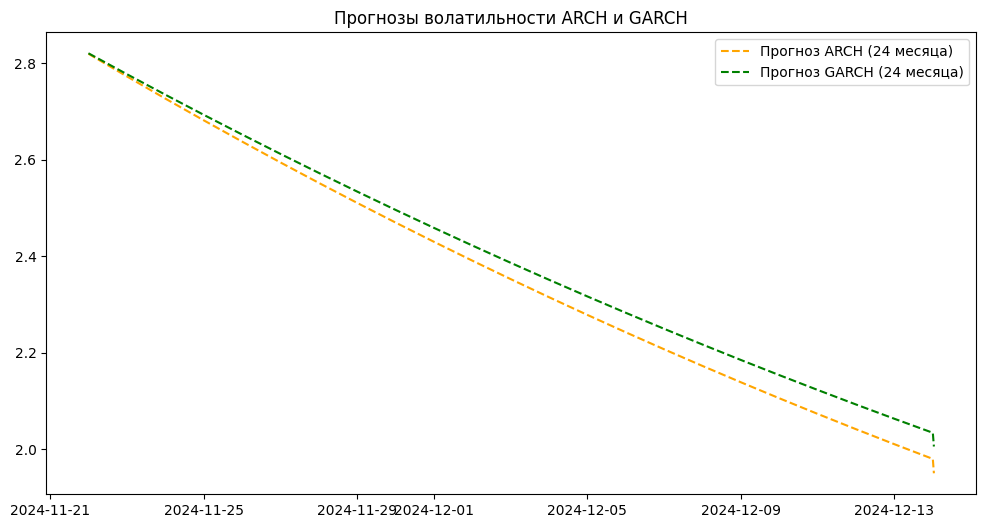

In [ ]:
from sklearn.preprocessing import StandardScaler

data = df[['Price']]  # Selecting 'Price' column and creating DataFrame

data['Price'] = data['Price'].fillna(data['Price'].mean())
train, test = data[:-24], data[-24:]

# Нормализация данных
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train['Price'].values.reshape(-1, 1))
test_scaled = scaler.transform(test['Price'].values.reshape(-1, 1))

# ARCH модель (попробуем различные параметры)
arch_model = arch.arch_model(train_scaled, vol='ARCH', p=1, q=1)
arch_result = arch_model.fit(disp="off")

# Прогнозирование волатильности на тестовой выборке
arch_volatility_forecast = arch_result.forecast(horizon=24).variance

# GARCH модель (попробуем различные параметры)
garch_model = arch.arch_model(train_scaled, vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp="off")

# Прогнозирование волатильности на тестовой выборке
garch_volatility_forecast = garch_result.forecast(horizon=24).variance.values  # Используем `.values` для получения массива

# Построение прогноза цен на основе волатильности
full_garch_forecast = garch_result.forecast(horizon=24)
full_garch_mean_forecast = full_garch_forecast.mean

# Графики прогнозов
plt.figure(figsize=(12, 6))
plt.plot(data.index[-24:], np.sqrt(arch_volatility_forecast.values[0]), label='Прогноз ARCH (24 месяца)', linestyle='--', color='orange')
plt.plot(data.index[-24:], np.sqrt(garch_volatility_forecast.flatten()), label='Прогноз GARCH (24 месяца)', linestyle='--', color='green') # Flatten the array
plt.title('Прогнозы волатильности ARCH и GARCH')
plt.legend()
plt.show()